# Profile Processing

In [356]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import detrend

## Functions to convert readings to uniform profile

In [357]:
def get_uniform_profile(t_reading, B_reading, t_stakes, x_stakes, dx):
    '''
    Calculate the magnetic field along a profile with a uniform spacing
    
    Input Parameters:
    ----------------
    
    t_reading:         reading time of the observation
    B_reading:         magnetic field at t_reading
    t_stakes:          time when the instrument is at a stake
    x_stakes:          location of the stakes along the profile
    dx:                distance interval spacing for the output
    
    Return:
    ------
    
    x_uniform:         locations along the profile
    B_uniform:         magnetic field along the profile
    
    '''
    
    # convert to time from reading to distance assuming the constant speed between 2 stakes
    t_reading_to_x_reading = interp1d(t_stakes, x_stakes, 'linear', fill_value="extrapolate")
    x_reading = t_reading_to_x_reading(t_reading)
    
    # resampling for uniform sampling interval
    x_uniform = np.arange(x_stakes[0], x_stakes[-1], dx)
    
    # interpolate the magnetic field from the reading locations to the uniform intervals
    B_reading_to_B_uniform = interp1d(x_reading, B_reading, 'nearest')
    B_uniform = B_reading_to_B_uniform(x_uniform)
    
    return x_uniform, B_uniform

## Test on the function

In [358]:
from pathlib import Path

stake_fname = 'Files/Stakes_example.csv'
reading_fname = 'Files/Magnetic_reading_example.csv'

stake_path = Path(stake_fname)
reading_path = Path(reading_fname)

if stake_path.is_file() and reading_path.is_file():
    df_reading = pd.read_csv(reading_fname)
    df_stake = pd.read_csv(stake_fname)

    t_reading = np.array(df_reading['time (s)'])
    B_reading = np.array(df_reading['magnetic field intensity (nT)'])
    
    t_stakes = np.array(df_stake['time (s)'])
    x_stakes = np.array(df_stake['location (m)'])
    
    # convert to time from reading to distance assuming the constant speed between 2 stakes
    t_reading_to_x_reading = interp1d(t_stakes, x_stakes, 'linear', fill_value="extrapolate")
    x_reading = t_reading_to_x_reading(t_reading)
else:
    # location of the stakes
    num_stakes = 24
    stake_spacing = 20     # meters
    x_stakes = stake_locations(num_stakes, stake_spacing)

    # time at each stakes
    # time at first stake
    t0 = 2 + 20 * np.random.rand(1)
    # each interval time between stakes is a random number between [50, 200) s
    t_laps = 50 + 150 * np.random.rand(num_stakes - 1)
    t_stakes = np.cumsum(np.append(t0, t_laps))

    # time from reading (synthetic)
    dt = 0.1
    t_reading = np.arange(0, 4800, dt)

    # convert to time from reading to distance assuming the constant speed between 2 stakes
    t_reading_to_x_reading = interp1d(t_stakes, x_stakes, 'linear', fill_value="extrapolate")
    x_reading = t_reading_to_x_reading(t_reading)

    # synthetic magnetic field intensity readings
    B_background = 51500
    B_reading_clean = true_anomaly(x_reading) + B_background

    P_signal = (np.max(np.abs(B_reading_clean - np.mean(B_reading_clean))) ** 2) / 2
    SNR = 20
    P_noise = P_signal / SNR

    B_noise = np.random.normal(0, np.sqrt(P_noise), np.size(x_reading))

    # magnetic field reading, noise included
    B_reading = B_reading_clean + B_noise

    # save the data
    df_reading = pd.DataFrame({'time (s)': t_reading,
                           'magnetic field intensity (nT)': B_reading})
    df_stake = pd.DataFrame({'time (s)': t_stakes,
                             'location (m)': x_stakes})

    df_reading.to_csv(reading_fname, index=False)
    df_stake.to_csv(stake_fname, index=False)

# demean and detrend
B_reading = detrend(B_reading, type='linear')

# resampling for uniform sampling interval
dx = 5
x_uniform, B_uniform = get_uniform_profile(t_reading, B_reading, t_stakes, x_stakes, dx)

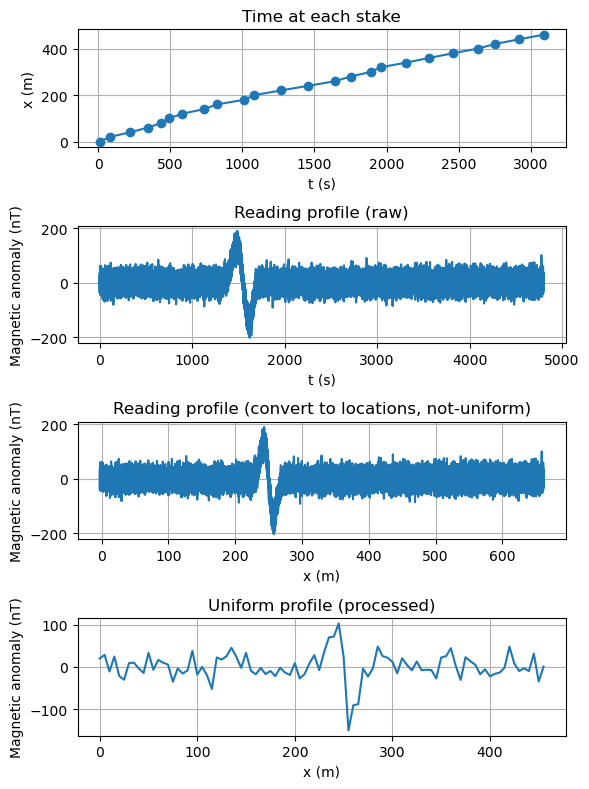

In [359]:
plt.figure(figsize=[6,8], dpi=100)
plt.subplot(4,1,1)
plt.plot(t_stakes,x_stakes, '-o')
plt.xlabel('t (s)')
plt.ylabel('x (m)')
plt.grid()
plt.title('Time at each stake')

plt.subplot(4,1,2)
plt.plot(t_reading, B_reading)
plt.xlabel('t (s)')
plt.ylabel('Magnetic anomaly (nT)')
plt.grid()
plt.title('Reading profile (raw)')

plt.subplot(4,1,3)
plt.plot(x_reading, B_reading)
plt.xlabel('x (m)')
plt.ylabel('Magnetic anomaly (nT)')
plt.grid()
plt.title('Reading profile (convert to locations, not-uniform)')

plt.subplot(4,1,4)
plt.plot(x_uniform, B_uniform)
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('Magnetic anomaly (nT)')
plt.title('Uniform profile (processed)')

plt.tight_layout()
plt.show()

## Moving average example

In [360]:
length_average = 5
v = np.ones(length_average) / length_average
B_uniform_moving = np.convolve(B_uniform, v, 'same')

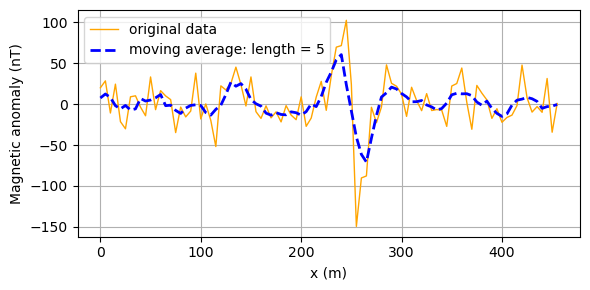

In [361]:
plt.figure(figsize=[6,3], dpi=100)
plt.plot(x_uniform, B_uniform, color='orange', linewidth=1, label="original data")
plt.plot(x_uniform, B_uniform_moving, '--b', linewidth=2, label="moving average: length = %d" % length_average)
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('Magnetic anomaly (nT)')
plt.legend()

plt.tight_layout()
plt.show()

## Helping functions for synthetic test

In [362]:
def stake_locations(num_stakes, stake_interval):
    x_stakes = np.arange(0, num_stakes) * stake_spacing
    return x_stakes

def stake_time(lap_times):
    t_stakes = np.cumsum(np.append(np.zeros(1), lap_times))
    return t_stakes

def true_anomaly(location):
    '''
    True anomaly (for testing purpose)
    It has a shape of 1st derivative of Gaussian centered at 250m and
    a length scale of 10 m.
    '''
    # central location
    x0 = 250
    # length scales
    x1 = 10
    # intensity scale
    B0 = 320
    
    # 1st derivative of Gaussian
    B = - B0 * (location - x0) / (x1) * np.exp(- ((location - x0) / x1) ** 2)
    return B

def profile_measurement_synthetic(dt=0.1, SNR=20, dx=5):
    '''
    Simulate a synthetic magnetic profile at a uniform spacing the way we do in the field. 
    
    Input Parameters:
    ----------------
    
    dt :               time interval spacing between readings (default = 0.1 s)
    SNR:               signal-to-noise ratio (default = 20)
    dx:                distance interval spacing for the output
    
    Return:
    ------
    
    x_uniform:         locations along the profile
    B_uniform:         magnetic field along the profile
    
    '''
    # location of the stakes
    num_stakes = 24
    stake_spacing = 20     # meters
    x_stakes = stake_locations(num_stakes, stake_spacing)
    
    # time at each stakes
    # each interval time between stakes is a random number between [50, 200) s
    t_laps = 50 + 150 * np.random.rand(num_stakes - 1)
    t_stakes = np.cumsum(np.append(np.zeros(1), t_laps))
    
    # time from reading (synthetic)
    t_reading = np.arange(0, t_stakes[-1], dt)
    
    # convert to time from reading to distance assuming the constant speed between 2 stakes
    t_reading_to_x_reading = interp1d(t_stakes, x_stakes, 'linear')
    x_reading = t_reading_to_x_reading(t_reading)
    
    # synthetic magnetic field intensity readings
    B_reading_clean = true_anomaly(x_reading)

    P_signal = (np.max(np.abs(B_reading_clean)) ** 2) / 2
    P_noise = P_signal / SNR

    B_noise = np.random.normal(0, np.sqrt(P_noise), np.size(x_reading))

    # magnetic field reading, noise included
    B_reading = B_reading_clean + B_noise
    
    # resampling for uniform sampling interval
    x_uniform = np.arange(x_stakes[0], x_reading[-1], dx)
    
    # interpolate the magnetic field from the reading locations to the uniform intervals
    B_reading_to_B_uniform = interp1d(x_reading, B_reading, 'nearest')
    B_uniform = B_reading_to_B_uniform(x_uniform)
    
    return x_uniform, B_uniform

## Synthetic example for stacking the magnetic anomaly readings

In [363]:
# Example on stacking 5 measurements
x1, B1 = profile_measurement_synthetic()
num_profiles = 5
x_all = np.empty((num_profiles, len(x1)))
B_all = np.empty((num_profiles, len(B1)))

x_all[0] = x1
B_all[0] = B1

for ii in range(1, num_profiles):
    x_all[ii], B_all[ii] = profile_measurement_synthetic()
    
# stack all measurements together
B_sum = np.sum(B_all, axis=0)

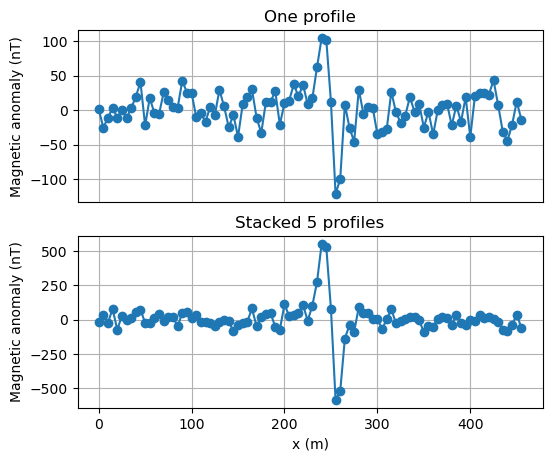

In [364]:
plt.figure(figsize=[6,5], dpi=100)
plt.subplot(2,1,1)
plt.plot(x1, B1, '-o')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('Magnetic anomaly (nT)')
plt.grid()
plt.title('One profile')

plt.subplot(2,1,2)
plt.plot(x1, B_sum, '-o')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('Magnetic anomaly (nT)')
plt.title('Stacked %d profiles' % num_profiles)
plt.show()